In [1]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from scipy.stats import skew
from scipy.stats.stats import pearsonr

In [46]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')


In [47]:
print train_df.shape
print test_df.shape

(4209, 378)
(4209, 377)


In [48]:
tall = pd.concat([train_df, test_df])
print tall.shape

(8418, 378)


In [42]:
tall.head()

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,k,v,at,a,d,u,j,o,0,...,0,0,1,0,0,0,0,0,0,0
1,6,k,t,av,e,d,y,l,o,0,...,1,0,0,0,0,0,0,0,0,0
2,7,az,w,n,c,d,x,j,x,0,...,0,0,0,0,0,0,1,0,0,0
3,9,az,t,n,f,d,x,l,e,0,...,0,0,0,0,0,0,0,0,0,0
4,13,az,v,n,f,d,h,d,n,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
cat_cols = list()
for i in train_df.columns:
    if train_df[i].dtype == 'object':
        cat_cols.append(i)
print len(cat_cols)

8


In [16]:


cat_df = pd.DataFrame([[]])
cat_df = pd.concat([cat_df, train_df['y']], axis=1)
for i in train_df:
    if train_df[i].dtype == 'object':
        cat_df = pd.concat([cat_df, train_df[i]], axis=1)
        
cat_df = cat_df.sort_values('y', ascending=False)

In [43]:
def do_cat_graph(df, cat):
    mean_df = pd.DataFrame(df[cat].unique(), columns=([cat]))
    mean_num_df = list()
    for i in train_df[cat].unique():
        mean_num_df.append(df.loc[df[cat] == i, 'y'].mean())
    df3 = pd.DataFrame(mean_num_df, columns=(['y']))
    mean_df = pd.concat([mean_df, df3], axis=1)
    mean_df = mean_df.sort_values(['y'], ascending=False)
    sns.barplot(y='y', x=cat, data=mean_df)
    return mean_df

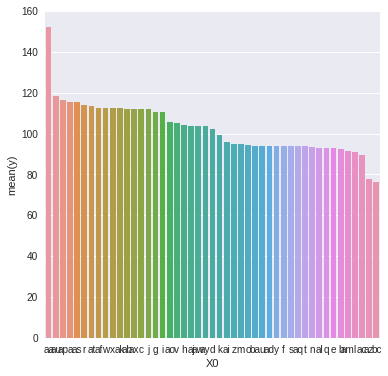

In [44]:
test_df = do_cat_graph(train_df, 'X0')

In [45]:
test_df.head()

,X0,y
29,aa,152.170000
39,au,118.695455
20,ap,116.577864
23,a,115.630952
31,as,115.349000


In [118]:
def cat_to_num(df1, df2):
    for i in cat_cols:
        d = {}
        numbs = range(0, len(df1[i].unique()))
        for x, y in zip(df1[i].unique(), numbs):
            d[x] = y
        for x,y in d.items():
            df1[i] = df1[i].replace(x, y)
            df2[i] = df1[i].replace(x, y)
            
    return (df1, df2)

In [119]:
train_df, test_df = cat_to_num(train_df, test_df)

In [49]:
df_with_dummies = pd.get_dummies(tall, columns=cat_cols)

In [56]:
train_df = df_with_dummies[0:4209]
train_df.shape

(4209, 581)

In [57]:
test_df = df_with_dummies[4209:]
test_df.shape

(4209, 581)

In [59]:
test_df = test_df.drop(['ID', 'y'], 1)
train_df = train_df.drop('ID', 1)

In [61]:
print test_df.shape
print train_df.shape


(4209, 579)
(4209, 580)
0    130.81
1     88.53
2     76.26
3     80.62
4     78.02
Name: y, dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f33a6646e90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f33a654be90>]], dtype=object)

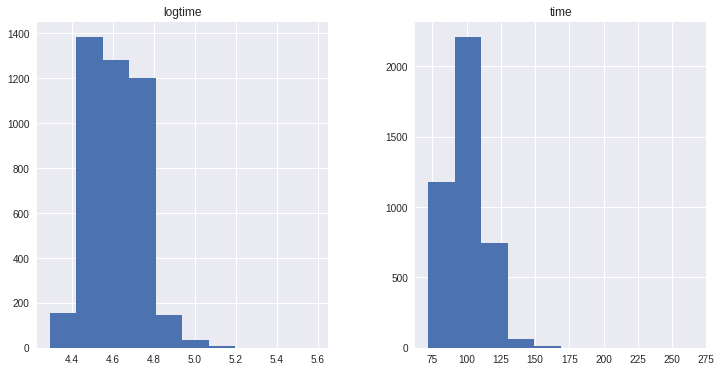

In [62]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
times = pd.DataFrame({'time': train_df['y'], 'logtime': np.log1p(train_df['y'])})
times.hist()

In [63]:
test_df = test_df.fillna(0)
train_df = train_df.fillna(0)

In [64]:
test_df.head()
len(test_df.columns)


579

In [66]:
train_df['y'] = np.log1p(train_df['y'])
y = train_df['y']
X_train = train_df.drop(['y'], 1)
X_test = test_df

In [67]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y, scoring='neg_mean_squared_error', cv = 5))
    return rmse


In [68]:
model_ridge = Ridge()

In [69]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha=alpha)).mean()
           for alpha in alphas]


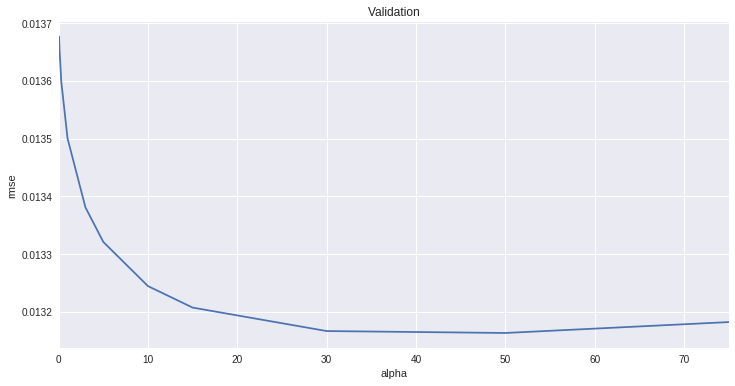

In [70]:
cv_ridge = pd.Series(cv_ridge, index=alphas)
cv_ridge.plot(title='Validation')
plt.ylabel('rmse')
plt.xlabel('alpha')

In [65]:
cv_ridge.min()

0.074963143639908913

In [66]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

In [67]:
rmse_cv(model_lasso).mean()

0.074374570919150937

In [68]:
coef = pd.Series(model_lasso.coef_, index=X_train.columns)

In [69]:
print 'Laso picked '+str(sum(coef != 0)) + ' variables and set ' + str(sum(coef ==0))+ ' to 0'

Laso picked 58 variables and set 505 to 0


In [27]:
imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])

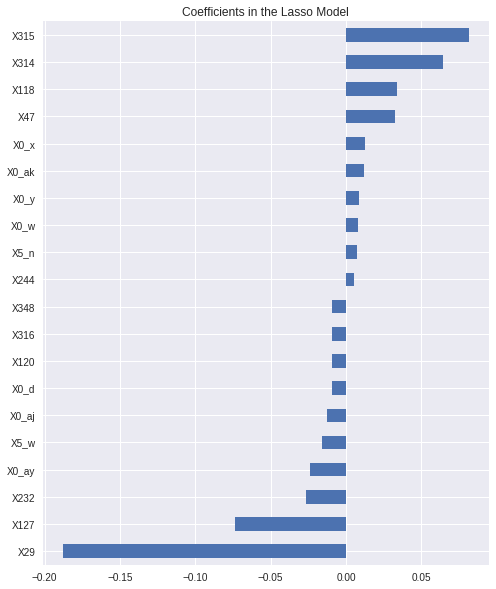

In [70]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind='barh')
plt.title('Coefficients in the Lasso Model')

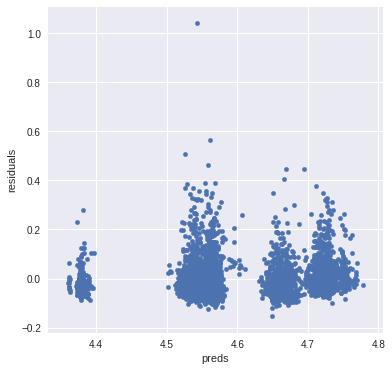

In [71]:
 matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({'preds': model_lasso.predict(X_train), 'true':y})
preds['residuals'] = preds['true'] - preds['preds']
preds.plot(x='preds', y='residuals', kind='scatter')

In [72]:
import xgboost as xgb

In [73]:
dtrain = xgb.DMatrix(X_train, label=y)
dtest = xgb.DMatrix(X_test)
params = {'max_depth': 2, 'eta': 0.1}
model = xgb.cv(params, dtrain, num_boost_round=500, early_stopping_rounds = 100)


ValueError: feature_names must be unique

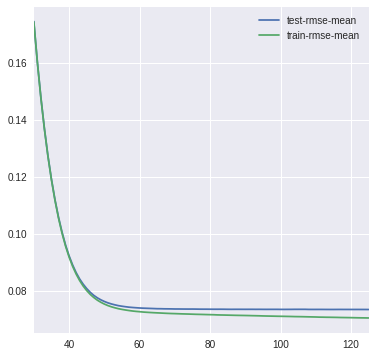

In [32]:
model.loc[30:, ['test-rmse-mean', 'train-rmse-mean']].plot()

In [33]:
model_xgb = xgb.XGBRegressor(n_estimators=100, max_depth=2, learning_rate=0.07)
model_xgb.fit(X_train, y)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.07, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [37]:
test_df.fillna(0)

,ID,X10,X11,X12,X13,X14,X15,X16,X17,X18,...,X0_an,X0_ae,X0_ag,X2_ab,X0_bb,X2_ad,X2_aj,X5_a,X5_b,X0_av
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,11,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,14,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))


ValueError: feature_names mismatch: [u'X10', u'X11', u'X12', u'X13', u'X14', u'X15', u'X16', u'X17', u'X18', u'X19', u'X20', u'X21', u'X22', u'X23', u'X24', u'X26', u'X27', u'X28', u'X29', u'X30', u'X31', u'X32', u'X33', u'X34', u'X35', u'X36', u'X37', u'X38', u'X39', u'X40', u'X41', u'X42', u'X43', u'X44', u'X45', u'X46', u'X47', u'X48', u'X49', u'X50', u'X51', u'X52', u'X53', u'X54', u'X55', u'X56', u'X57', u'X58', u'X59', u'X60', u'X61', u'X62', u'X63', u'X64', u'X65', u'X66', u'X67', u'X68', u'X69', u'X70', u'X71', u'X73', u'X74', u'X75', u'X76', u'X77', u'X78', u'X79', u'X80', u'X81', u'X82', u'X83', u'X84', u'X85', u'X86', u'X87', u'X88', u'X89', u'X90', u'X91', u'X92', u'X93', u'X94', u'X95', u'X96', u'X97', u'X98', u'X99', u'X100', u'X101', u'X102', u'X103', u'X104', u'X105', u'X106', u'X107', u'X108', u'X109', u'X110', u'X111', u'X112', u'X113', u'X114', u'X115', u'X116', u'X117', u'X118', u'X119', u'X120', u'X122', u'X123', u'X124', u'X125', u'X126', u'X127', u'X128', u'X129', u'X130', u'X131', u'X132', u'X133', u'X134', u'X135', u'X136', u'X137', u'X138', u'X139', u'X140', u'X141', u'X142', u'X143', u'X144', u'X145', u'X146', u'X147', u'X148', u'X150', u'X151', u'X152', u'X153', u'X154', u'X155', u'X156', u'X157', u'X158', u'X159', u'X160', u'X161', u'X162', u'X163', u'X164', u'X165', u'X166', u'X167', u'X168', u'X169', u'X170', u'X171', u'X172', u'X173', u'X174', u'X175', u'X176', u'X177', u'X178', u'X179', u'X180', u'X181', u'X182', u'X183', u'X184', u'X185', u'X186', u'X187', u'X189', u'X190', u'X191', u'X192', u'X194', u'X195', u'X196', u'X197', u'X198', u'X199', u'X200', u'X201', u'X202', u'X203', u'X204', u'X205', u'X206', u'X207', u'X208', u'X209', u'X210', u'X211', u'X212', u'X213', u'X214', u'X215', u'X216', u'X217', u'X218', u'X219', u'X220', u'X221', u'X222', u'X223', u'X224', u'X225', u'X226', u'X227', u'X228', u'X229', u'X230', u'X231', u'X232', u'X233', u'X234', u'X235', u'X236', u'X237', u'X238', u'X239', u'X240', u'X241', u'X242', u'X243', u'X244', u'X245', u'X246', u'X247', u'X248', u'X249', u'X250', u'X251', u'X252', u'X253', u'X254', u'X255', u'X256', u'X257', u'X258', u'X259', u'X260', u'X261', u'X262', u'X263', u'X264', u'X265', u'X266', u'X267', u'X268', u'X269', u'X270', u'X271', u'X272', u'X273', u'X274', u'X275', u'X276', u'X277', u'X278', u'X279', u'X280', u'X281', u'X282', u'X283', u'X284', u'X285', u'X286', u'X287', u'X288', u'X289', u'X290', u'X291', u'X292', u'X293', u'X294', u'X295', u'X296', u'X297', u'X298', u'X299', u'X300', u'X301', u'X302', u'X304', u'X305', u'X306', u'X307', u'X308', u'X309', u'X310', u'X311', u'X312', u'X313', u'X314', u'X315', u'X316', u'X317', u'X318', u'X319', u'X320', u'X321', u'X322', u'X323', u'X324', u'X325', u'X326', u'X327', u'X328', u'X329', u'X330', u'X331', u'X332', u'X333', u'X334', u'X335', u'X336', u'X337', u'X338', u'X339', u'X340', u'X341', u'X342', u'X343', u'X344', u'X345', u'X346', u'X347', u'X348', u'X349', u'X350', u'X351', u'X352', u'X353', u'X354', u'X355', u'X356', u'X357', u'X358', u'X359', u'X360', u'X361', u'X362', u'X363', u'X364', u'X365', u'X366', u'X367', u'X368', u'X369', u'X370', u'X371', u'X372', u'X373', u'X374', u'X375', u'X376', u'X377', u'X378', u'X379', u'X380', u'X382', u'X383', u'X384', u'X385', u'X0_a', u'X0_aa', u'X0_ab', u'X0_ac', u'X0_ad', u'X0_af', u'X0_ai', u'X0_aj', u'X0_ak', u'X0_al', u'X0_am', u'X0_ao', u'X0_ap', u'X0_aq', u'X0_as', u'X0_at', u'X0_au', u'X0_aw', u'X0_ax', u'X0_ay', u'X0_az', u'X0_b', u'X0_ba', u'X0_bc', u'X0_c', u'X0_d', u'X0_e', u'X0_f', u'X0_g', u'X0_h', u'X0_i', u'X0_j', u'X0_k', u'X0_l', u'X0_m', u'X0_n', u'X0_o', u'X0_q', u'X0_r', u'X0_s', u'X0_t', u'X0_u', u'X0_v', u'X0_w', u'X0_x', u'X0_y', u'X0_z', u'X1_a', u'X1_aa', u'X1_ab', u'X1_b', u'X1_c', u'X1_d', u'X1_e', u'X1_f', u'X1_g', u'X1_h', u'X1_i', u'X1_j', u'X1_k', u'X1_l', u'X1_m', u'X1_n', u'X1_o', u'X1_p', u'X1_q', u'X1_r', u'X1_s', u'X1_t', u'X1_u', u'X1_v', u'X1_w', u'X1_y', u'X1_z', u'X2_a', u'X2_aa', u'X2_ac', u'X2_ae', u'X2_af', u'X2_ag', u'X2_ah', u'X2_ai', u'X2_ak', u'X2_al', u'X2_am', u'X2_an', u'X2_ao', u'X2_ap', u'X2_aq', u'X2_ar', u'X2_as', u'X2_at', u'X2_au', u'X2_av', u'X2_aw', u'X2_ay', u'X2_b', u'X2_c', u'X2_d', u'X2_e', u'X2_f', u'X2_g', u'X2_h', u'X2_i', u'X2_j', u'X2_k', u'X2_l', u'X2_m', u'X2_n', u'X2_o', u'X2_p', u'X2_q', u'X2_r', u'X2_s', u'X2_t', u'X2_x', u'X2_y', u'X2_z', u'X3_a', u'X3_b', u'X3_c', u'X3_d', u'X3_e', u'X3_f', u'X3_g', u'X4_a', u'X4_b', u'X4_c', u'X4_d', u'X5_aa', u'X5_ab', u'X5_ac', u'X5_ad', u'X5_ae', u'X5_af', u'X5_ag', u'X5_ah', u'X5_c', u'X5_d', u'X5_f', u'X5_g', u'X5_h', u'X5_i', u'X5_j', u'X5_k', u'X5_l', u'X5_m', u'X5_n', u'X5_o', u'X5_p', u'X5_q', u'X5_r', u'X5_s', u'X5_u', u'X5_v', u'X5_w', u'X5_x', u'X5_y', u'X6_a', u'X6_b', u'X6_c', u'X6_d', u'X6_e', u'X6_f', u'X6_g', u'X6_h', u'X6_i', u'X6_j', u'X6_k', u'X6_l', u'X8_a', u'X8_b', u'X8_c', u'X8_d', u'X8_e', u'X8_f', u'X8_g', u'X8_h', u'X8_i', u'X8_j', u'X8_k', u'X8_l', u'X8_m', u'X8_n', u'X8_o', u'X8_p', u'X8_q', u'X8_r', u'X8_s', u'X8_t', u'X8_u', u'X8_v', u'X8_w', u'X8_x', u'X8_y'] [u'X10', u'X11', u'X12', u'X13', u'X14', u'X15', u'X16', u'X17', u'X18', u'X19', u'X20', u'X21', u'X22', u'X23', u'X24', u'X26', u'X27', u'X28', u'X29', u'X30', u'X31', u'X32', u'X33', u'X34', u'X35', u'X36', u'X37', u'X38', u'X39', u'X40', u'X41', u'X42', u'X43', u'X44', u'X45', u'X46', u'X47', u'X48', u'X49', u'X50', u'X51', u'X52', u'X53', u'X54', u'X55', u'X56', u'X57', u'X58', u'X59', u'X60', u'X61', u'X62', u'X63', u'X64', u'X65', u'X66', u'X67', u'X68', u'X69', u'X70', u'X71', u'X73', u'X74', u'X75', u'X76', u'X77', u'X78', u'X79', u'X80', u'X81', u'X82', u'X83', u'X84', u'X85', u'X86', u'X87', u'X88', u'X89', u'X90', u'X91', u'X92', u'X93', u'X94', u'X95', u'X96', u'X97', u'X98', u'X99', u'X100', u'X101', u'X102', u'X103', u'X104', u'X105', u'X106', u'X107', u'X108', u'X109', u'X110', u'X111', u'X112', u'X113', u'X114', u'X115', u'X116', u'X117', u'X118', u'X119', u'X120', u'X122', u'X123', u'X124', u'X125', u'X126', u'X127', u'X128', u'X129', u'X130', u'X131', u'X132', u'X133', u'X134', u'X135', u'X136', u'X137', u'X138', u'X139', u'X140', u'X141', u'X142', u'X143', u'X144', u'X145', u'X146', u'X147', u'X148', u'X150', u'X151', u'X152', u'X153', u'X154', u'X155', u'X156', u'X157', u'X158', u'X159', u'X160', u'X161', u'X162', u'X163', u'X164', u'X165', u'X166', u'X167', u'X168', u'X169', u'X170', u'X171', u'X172', u'X173', u'X174', u'X175', u'X176', u'X177', u'X178', u'X179', u'X180', u'X181', u'X182', u'X183', u'X184', u'X185', u'X186', u'X187', u'X189', u'X190', u'X191', u'X192', u'X194', u'X195', u'X196', u'X197', u'X198', u'X199', u'X200', u'X201', u'X202', u'X203', u'X204', u'X205', u'X206', u'X207', u'X208', u'X209', u'X210', u'X211', u'X212', u'X213', u'X214', u'X215', u'X216', u'X217', u'X218', u'X219', u'X220', u'X221', u'X222', u'X223', u'X224', u'X225', u'X226', u'X227', u'X228', u'X229', u'X230', u'X231', u'X232', u'X233', u'X234', u'X235', u'X236', u'X237', u'X238', u'X239', u'X240', u'X241', u'X242', u'X243', u'X244', u'X245', u'X246', u'X247', u'X248', u'X249', u'X250', u'X251', u'X252', u'X253', u'X254', u'X255', u'X256', u'X257', u'X258', u'X259', u'X260', u'X261', u'X262', u'X263', u'X264', u'X265', u'X266', u'X267', u'X268', u'X269', u'X270', u'X271', u'X272', u'X273', u'X274', u'X275', u'X276', u'X277', u'X278', u'X279', u'X280', u'X281', u'X282', u'X283', u'X284', u'X285', u'X286', u'X287', u'X288', u'X289', u'X290', u'X291', u'X292', u'X293', u'X294', u'X295', u'X296', u'X297', u'X298', u'X299', u'X300', u'X301', u'X302', u'X304', u'X305', u'X306', u'X307', u'X308', u'X309', u'X310', u'X311', u'X312', u'X313', u'X314', u'X315', u'X316', u'X317', u'X318', u'X319', u'X320', u'X321', u'X322', u'X323', u'X324', u'X325', u'X326', u'X327', u'X328', u'X329', u'X330', u'X331', u'X332', u'X333', u'X334', u'X335', u'X336', u'X337', u'X338', u'X339', u'X340', u'X341', u'X342', u'X343', u'X344', u'X345', u'X346', u'X347', u'X348', u'X349', u'X350', u'X351', u'X352', u'X353', u'X354', u'X355', u'X356', u'X357', u'X358', u'X359', u'X360', u'X361', u'X362', u'X363', u'X364', u'X365', u'X366', u'X367', u'X368', u'X369', u'X370', u'X371', u'X372', u'X373', u'X374', u'X375', u'X376', u'X377', u'X378', u'X379', u'X380', u'X382', u'X383', u'X384', u'X385', u'X0_a', u'X0_ad', u'X0_ae', u'X0_af', u'X0_ag', u'X0_ai', u'X0_aj', u'X0_ak', u'X0_al', u'X0_am', u'X0_an', u'X0_ao', u'X0_ap', u'X0_aq', u'X0_as', u'X0_at', u'X0_au', u'X0_av', u'X0_aw', u'X0_ax', u'X0_ay', u'X0_az', u'X0_b', u'X0_ba', u'X0_bb', u'X0_bc', u'X0_c', u'X0_d', u'X0_e', u'X0_f', u'X0_g', u'X0_h', u'X0_i', u'X0_j', u'X0_k', u'X0_l', u'X0_m', u'X0_n', u'X0_o', u'X0_p', u'X0_r', u'X0_s', u'X0_t', u'X0_u', u'X0_v', u'X0_w', u'X0_x', u'X0_y', u'X0_z', u'X1_a', u'X1_aa', u'X1_ab', u'X1_b', u'X1_c', u'X1_d', u'X1_e', u'X1_f', u'X1_g', u'X1_h', u'X1_i', u'X1_j', u'X1_k', u'X1_l', u'X1_m', u'X1_n', u'X1_o', u'X1_p', u'X1_q', u'X1_r', u'X1_s', u'X1_t', u'X1_u', u'X1_v', u'X1_w', u'X1_y', u'X1_z', u'X2_a', u'X2_ab', u'X2_ac', u'X2_ad', u'X2_ae', u'X2_af', u'X2_ag', u'X2_ah', u'X2_ai', u'X2_aj', u'X2_ak', u'X2_al', u'X2_am', u'X2_an', u'X2_ao', u'X2_ap', u'X2_aq', u'X2_as', u'X2_at', u'X2_au', u'X2_av', u'X2_aw', u'X2_ax', u'X2_ay', u'X2_b', u'X2_d', u'X2_e', u'X2_f', u'X2_g', u'X2_h', u'X2_i', u'X2_j', u'X2_k', u'X2_m', u'X2_n', u'X2_p', u'X2_q', u'X2_r', u'X2_s', u'X2_t', u'X2_u', u'X2_w', u'X2_x', u'X2_y', u'X2_z', u'X3_a', u'X3_b', u'X3_c', u'X3_d', u'X3_e', u'X3_f', u'X3_g', u'X4_a', u'X4_b', u'X4_c', u'X4_d', u'X5_a', u'X5_aa', u'X5_ab', u'X5_ac', u'X5_ad', u'X5_ae', u'X5_af', u'X5_ag', u'X5_ah', u'X5_b', u'X5_c', u'X5_d', u'X5_f', u'X5_g', u'X5_h', u'X5_i', u'X5_j', u'X5_k', u'X5_l', u'X5_m', u'X5_n', u'X5_o', u'X5_p', u'X5_q', u'X5_r', u'X5_s', u'X5_t', u'X5_v', u'X5_w', u'X5_x', u'X5_y', u'X5_z', u'X6_a', u'X6_b', u'X6_c', u'X6_d', u'X6_e', u'X6_f', u'X6_g', u'X6_h', u'X6_i', u'X6_j', u'X6_k', u'X6_l', u'X8_a', u'X8_b', u'X8_c', u'X8_d', u'X8_e', u'X8_f', u'X8_g', u'X8_h', u'X8_i', u'X8_j', u'X8_k', u'X8_l', u'X8_m', u'X8_n', u'X8_o', u'X8_p', u'X8_q', u'X8_r', u'X8_s', u'X8_t', u'X8_u', u'X8_v', u'X8_w', u'X8_x', u'X8_y']
expected X2_ar, X0_aa, X5_u, X0_ac, X0_ab, X0_q, X2_aa, X2_c, X2_o, X2_l in input data
training data did not have the following fields: X2_w, X2_u, X2_ax, X5_z, X0_p, X5_t, X0_an, X0_ae, X0_ag, X2_ab, X0_bb, X2_ad, X2_aj, X5_a, X5_b, X0_av

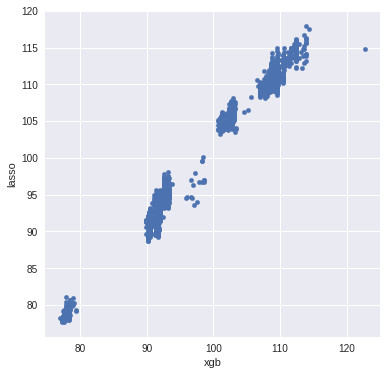

In [140]:
predictions = pd.DataFrame({'xgb': xgb_preds, 'lasso':lasso_preds})
predictions.plot(x='xgb', y='lasso', kind='scatter')

In [141]:
preds = xgb_preds

In [142]:
preds.shape

(4209,)

In [143]:
solution = pd.DataFrame({'id':test_df['ID'], 'y':preds})
solution.tail()

,id,y
4204,8410,101.076195
4205,8411,91.571671
4206,8413,90.172340
4207,8414,107.675919
4208,8416,91.611763


In [77]:
len(preds)

4209

In [78]:
test_df['ID'].tail()

4204    8410
4205    8411
4206    8413
4207    8414
4208    8416
Name: ID, dtype: int64

In [144]:
solution.to_csv('just_xgb.csv', index=False)